# Predicting the Cellular Localization Sites of Proteins

Dataset: https://archive.ics.uci.edu/ml/datasets/Yeast

## Introduction

Proteins are biochemical compounds that have unique amino acid sequences based on the expression of a cell’s genetic code (Hung & Link, 2011). Cells are organized into different compartments called organelles such as the nucleus, endoplasmic reticulum and mitochondria. After proteins are produced in the cytosol, they are targeted to these specific localization sites (Nakai & Kanehisa, 1992). Although there are several methods for protein transport, the amino acid sequence of a protein often acts as a sorting signal that is recognized by receptors which guide them to their target location (MBInfo, 2017; Nakai & Kanehisa, 1991). By identifying features of this sequence, we can determine what types of proteins will travel to specific regions. It is important for proteins to reach their appropriate sites as this will affect their functionality and accessibility (Horton & Nakai, 1996; Nakai & Kanehisa, 1991).         

We will be using the Yeast Data Set provided by the UCI Machine Learning Repository for this project. Our objective is to design a model that will accurately predict where proteins will be localized in a yeast cell. The data set consists of 8 attributes relevant to our analysis, represented as conditional probabilities between 0 and 1.0, where a higher score corresponds to a higher possibility that the protein sequence contains a certain feature (Horton & Nakai, 1996).


Feature List  <br>
mcg: signal sequence  <br>
gvh: cleavable signal sequence  <br>
alm: membrane spanning regions  <br>
mit: mitochondrial residues   <br>
erl: HDEL retention pattern   <br>
pox: peroxisomal targeting signal   <br>
vac: vacuolar/extracellular amino acids  <br>
nuc: nuclear localization pattern  

The names of each corresponding yeast gene were also included but they were not needed for our model and were purely for human readability. This data can be used to classify proteins into 10 different sites: ‘CYT’ (cytosol or cytoskeleton), ‘NUC’ (nucleus), ‘MIT’ (mitochondria), ‘ME3’ (membrane protein without N-terminal signal), ‘ME2’ (membrane protein with signal uncleaved), ‘ME1’ (membrane protein with signal cleaved), ‘EXC’ (extracellular space), ‘VAC’ (vacuole), ‘POX’ (peroxisome) or ‘ERL’ (endoplasmic reticulum lumen) (Nakai & Kanehisa, 1992). Our question is: Can we identify where a protein will be localized in a yeast cell based on these attributes within our model? We hypothesize that these attributes will display a relatively unique set of values for each location, and therefore we should be capable of determining the final location of any yeast protein. If we are able to extract relationships between the predictors and the classes, we have the potential to determine a connection between yeast and human cells.


## Methods & Results

To clean the data we first added column names to the original dataset. We then converted columns with predictive attributes to numeric type and scale the data.    


We found that all eight predictors are closely related to the localization site and are well separated, with no redundant variables that are strongly correlated (as can be seen from the plot using ggpairs). Therefore, we kept all eight attributes as predictors.

The classes are imbalanced, with minority classes such as ERL (4, 0.38%), POX (14, 1.3%) VAC (21, 2%). One approach is to disregard these classes. However, as there are 6 classes occupying less than 4% of the data, we would lose too many classes, and some predictors related to those classes would be useless. Therefore, we chose to up-sample the minority classes using the upSample function in caret. Then we performed a 10-fold cross-validation and selected the best k value that maximizes the accuracy, using the k-accuracy plot. After re-training the classifier with the selected k (k=2), the prediction on the testing set was made and we obtained model quality using the confusion matrix. The overall prediction accuracy is 51.5%.


 Finally, we visualized the classification results, using:
1. Visualized version of the confusionMatrix. i.e. a 10 by 10 matrix with aij being the number of cases that are predicted as class i and have real class j. The colors of the blocks vary from light to dark, indicating frequency.
2. A bar plot summarizing the proportion of correct predictions for each class


### code

In [1]:
library(tidyverse)
library(repr)
library(caret)
library(GGally)
install.packages('e1071', dependencies=TRUE)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.1
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.0’
(as ‘lib’ is unspecified)



In [2]:
# read dataset
yeast_url <- 'http://archive.ics.uci.edu/ml/machine-learning-databases/yeast/yeast.data'
yeast_data <- read_delim(yeast_url, delim = '  ', col_name = F)


Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_character(),
  X3 = col_character(),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character(),
  X7 = col_character(),
  X8 = col_character(),
  X9 = col_character(),
  X10 = col_character()
)



In [3]:
yeast_data = as.data.frame(yeast_data)

In [4]:
# preprocess the dataset
colnames(yeast_data) <- c('name', 'mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc', 'class')
cols <- 2:9
yeast_data[cols] <- as.numeric(unlist(yeast_data[cols]))

clean_yeast_data <- yeast_data %>%
    select(-name) %>%
    mutate(class = as.factor(class))

In [5]:
# split into training and testing set
set.seed(1234)
training_rows <- clean_yeast_data %>% 
  select(class) %>% 
  unlist() %>%
  createDataPartition(p = 0.70, list = FALSE)

training_set <- clean_yeast_data %>% slice(training_rows)
testing_set <- clean_yeast_data %>% slice(-training_rows)


In [6]:
# Scale Data (Using Only Training Data)
scale_transformer <- preProcess(training_set, method = c("range"))
training_set <- predict(scale_transformer, training_set)
testing_set <- predict(scale_transformer, testing_set)


In [7]:
# exploratory data analysis 1

# Make Summary Table
summary_table <- training_set %>%
    group_by(class) %>%
    summarize(n = n(), mcg_avg = mean(mcg), gvh_avg = mean(gvh), alm_avg = mean(alm), mit_avg = mean(mit), 
              erl_avg = mean(erl), pox_avg = mean(pox), vac_avg = mean(vac), nuc_avg = mean(nuc))
    
head(training_set)
head(summary_table)


`summarise()` ungrouping output (override with `.groups` argument)



,mcg,gvh,alm,mit,erl,pox,vac,nuc,class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0.3132530,0.6710526,0.3417722,0.27,0,0,0.7260274,0.2222222,MIT
2,0.5662651,0.6052632,0.3544304,0.15,0,0,0.7260274,0.2222222,MIT
3,0.3012048,0.3684211,0.3417722,0.54,0,0,0.6575342,0.2222222,MIT
4,0.3734940,0.3815789,0.4810127,0.20,0,0,0.7945205,0.3434343,NUC
5,0.4578313,0.4473684,0.5696203,0.36,0,0,0.6712329,0.2222222,MIT
6,0.2771084,0.3026316,0.4936709,0.15,0,0,0.7945205,0.3030303,CYT


class,n,mcg_avg,gvh_avg,alm_avg,mit_avg,erl_avg,pox_avg,vac_avg,nuc_avg
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CYT,325,0.3718628,0.4038462,0.4125414,0.2277231,0.009230769,0,0.6839199,0.2567521
ERL,4,0.7319277,0.8750000,0.3924051,0.3250000,1.000000000,0,0.7465753,0.2474747
EXC,25,0.6737349,0.7226316,0.3640506,0.2820000,0.000000000,0,0.6241096,0.2262626
ME1,31,0.7590361,0.7843803,0.2176399,0.3209677,0.000000000,0,0.7003977,0.2828283
ME2,36,0.6670013,0.5778509,0.2644163,0.2741667,0.000000000,0,0.7176560,0.2488777
ME3,115,0.3082242,0.4283753,0.1969180,0.2206957,0.000000000,0,0.6969625,0.2717611


Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation i

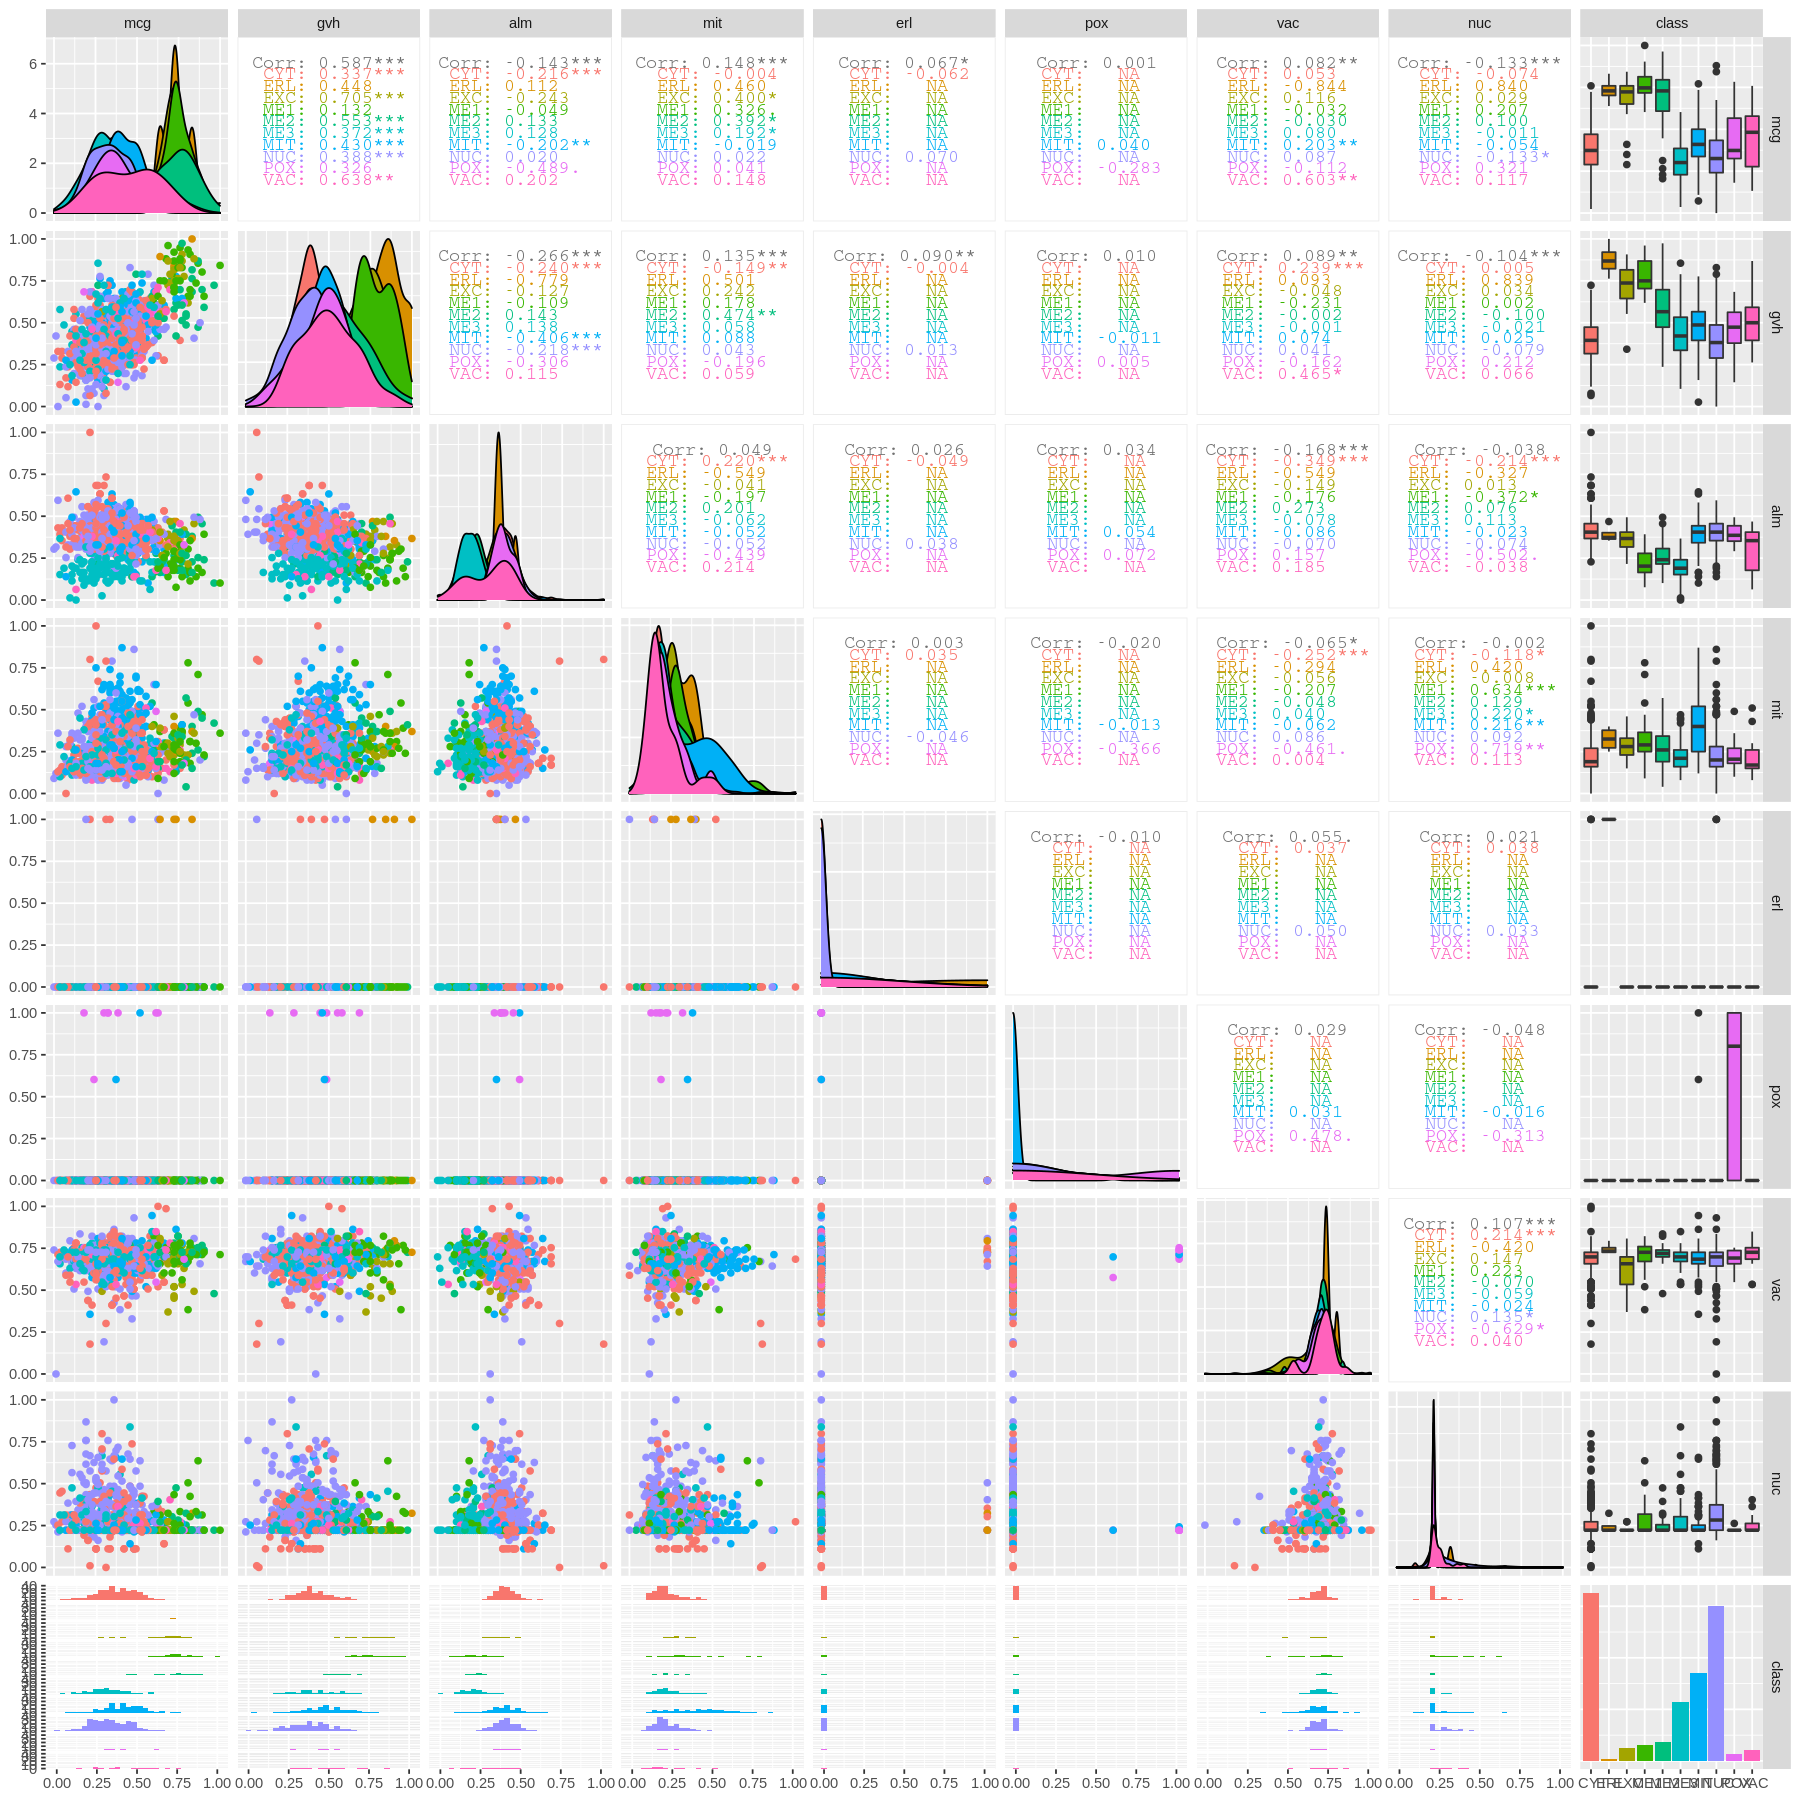

In [8]:
# exploratory data analysis 2

# Visualise variable relationships with ggpairs
options(repr.plot.width = 15, repr.plot.height = 15) 
ggp <- ggpairs(training_set, ggplot2::aes(colour=class), progress = F)
ggp


In [9]:
training_set <- training_set[,c(1:9)]
training_set <- as.data.frame(training_set)


In [10]:
# Number of each class
table(training_set$class )


 CYT  ERL  EXC  ME1  ME2  ME3  MIT  NUC  POX  VAC 
 325    4   25   31   36  115  171  301   14   21 

In [11]:
# Up-sampling to balance class
balanced_training_set <- upSample(x=select(training_set, -class),
                                  y= select(training_set, class) %>% unlist())  
balanced_training_set %>% 
    group_by(Class) %>%
    summarize(n = n())    
      

`summarise()` ungrouping output (override with `.groups` argument)



Class,n
<fct>,<int>
CYT,325
ERL,325
EXC,325
ME1,325
ME2,325
ME3,325
MIT,325
NUC,325
POX,325


In [12]:
balanced_X_train <- balanced_training_set %>% select(-Class) %>% data.frame()
balanced_Y_train <- balanced_training_set %>% select(Class) %>% unlist()
X_train <- training_set %>% select(-class) %>% data.frame()
Y_train <- training_set %>% select(class) %>% unlist()

In [13]:
# Parameter value selection
ks <- data.frame(k = seq(from = 1, to = 99, by = 2))

In [14]:
# Cross-validation
train_control <- trainControl(method="cv", number = 5)

In [15]:
# training using balanced data
set.seed(1234)
classifier_ks <- train(x= X_train, y= Y_train, method="knn", tuneGrid= ks, trControl=train_control)
classifier_ks

k-Nearest Neighbors 

1043 samples
   8 predictor
  10 classes: ' CYT', ' ERL', ' EXC', ' ME1', ' ME2', ' ME3', ' MIT', ' NUC', ' POX', ' VAC' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 835, 836, 832, 834, 835 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   1  0.4889255  0.3412054
   3  0.5311613  0.3927150
   5  0.5550081  0.4203462
   7  0.5474203  0.4093126
   9  0.5549982  0.4178141
  11  0.5616606  0.4262978
  13  0.5635287  0.4285788
  15  0.5626310  0.4268964
  17  0.5578877  0.4202208
  19  0.5579014  0.4199702
  21  0.5569257  0.4181858
  23  0.5628004  0.4241926
  25  0.5627592  0.4238164
  27  0.5732219  0.4374722
  29  0.5665688  0.4281538
  31  0.5665873  0.4279413
  33  0.5732083  0.4365906
  35  0.5723518  0.4352679
  37  0.5579742  0.4162275
  39  0.5598654  0.4185482
  41  0.5569487  0.4139175
  43  0.5588625  0.4166616
  45  0.5636568  0.4226652
  47  0.5607721  0.4189967
  49  0.5598246  0.4171002
 

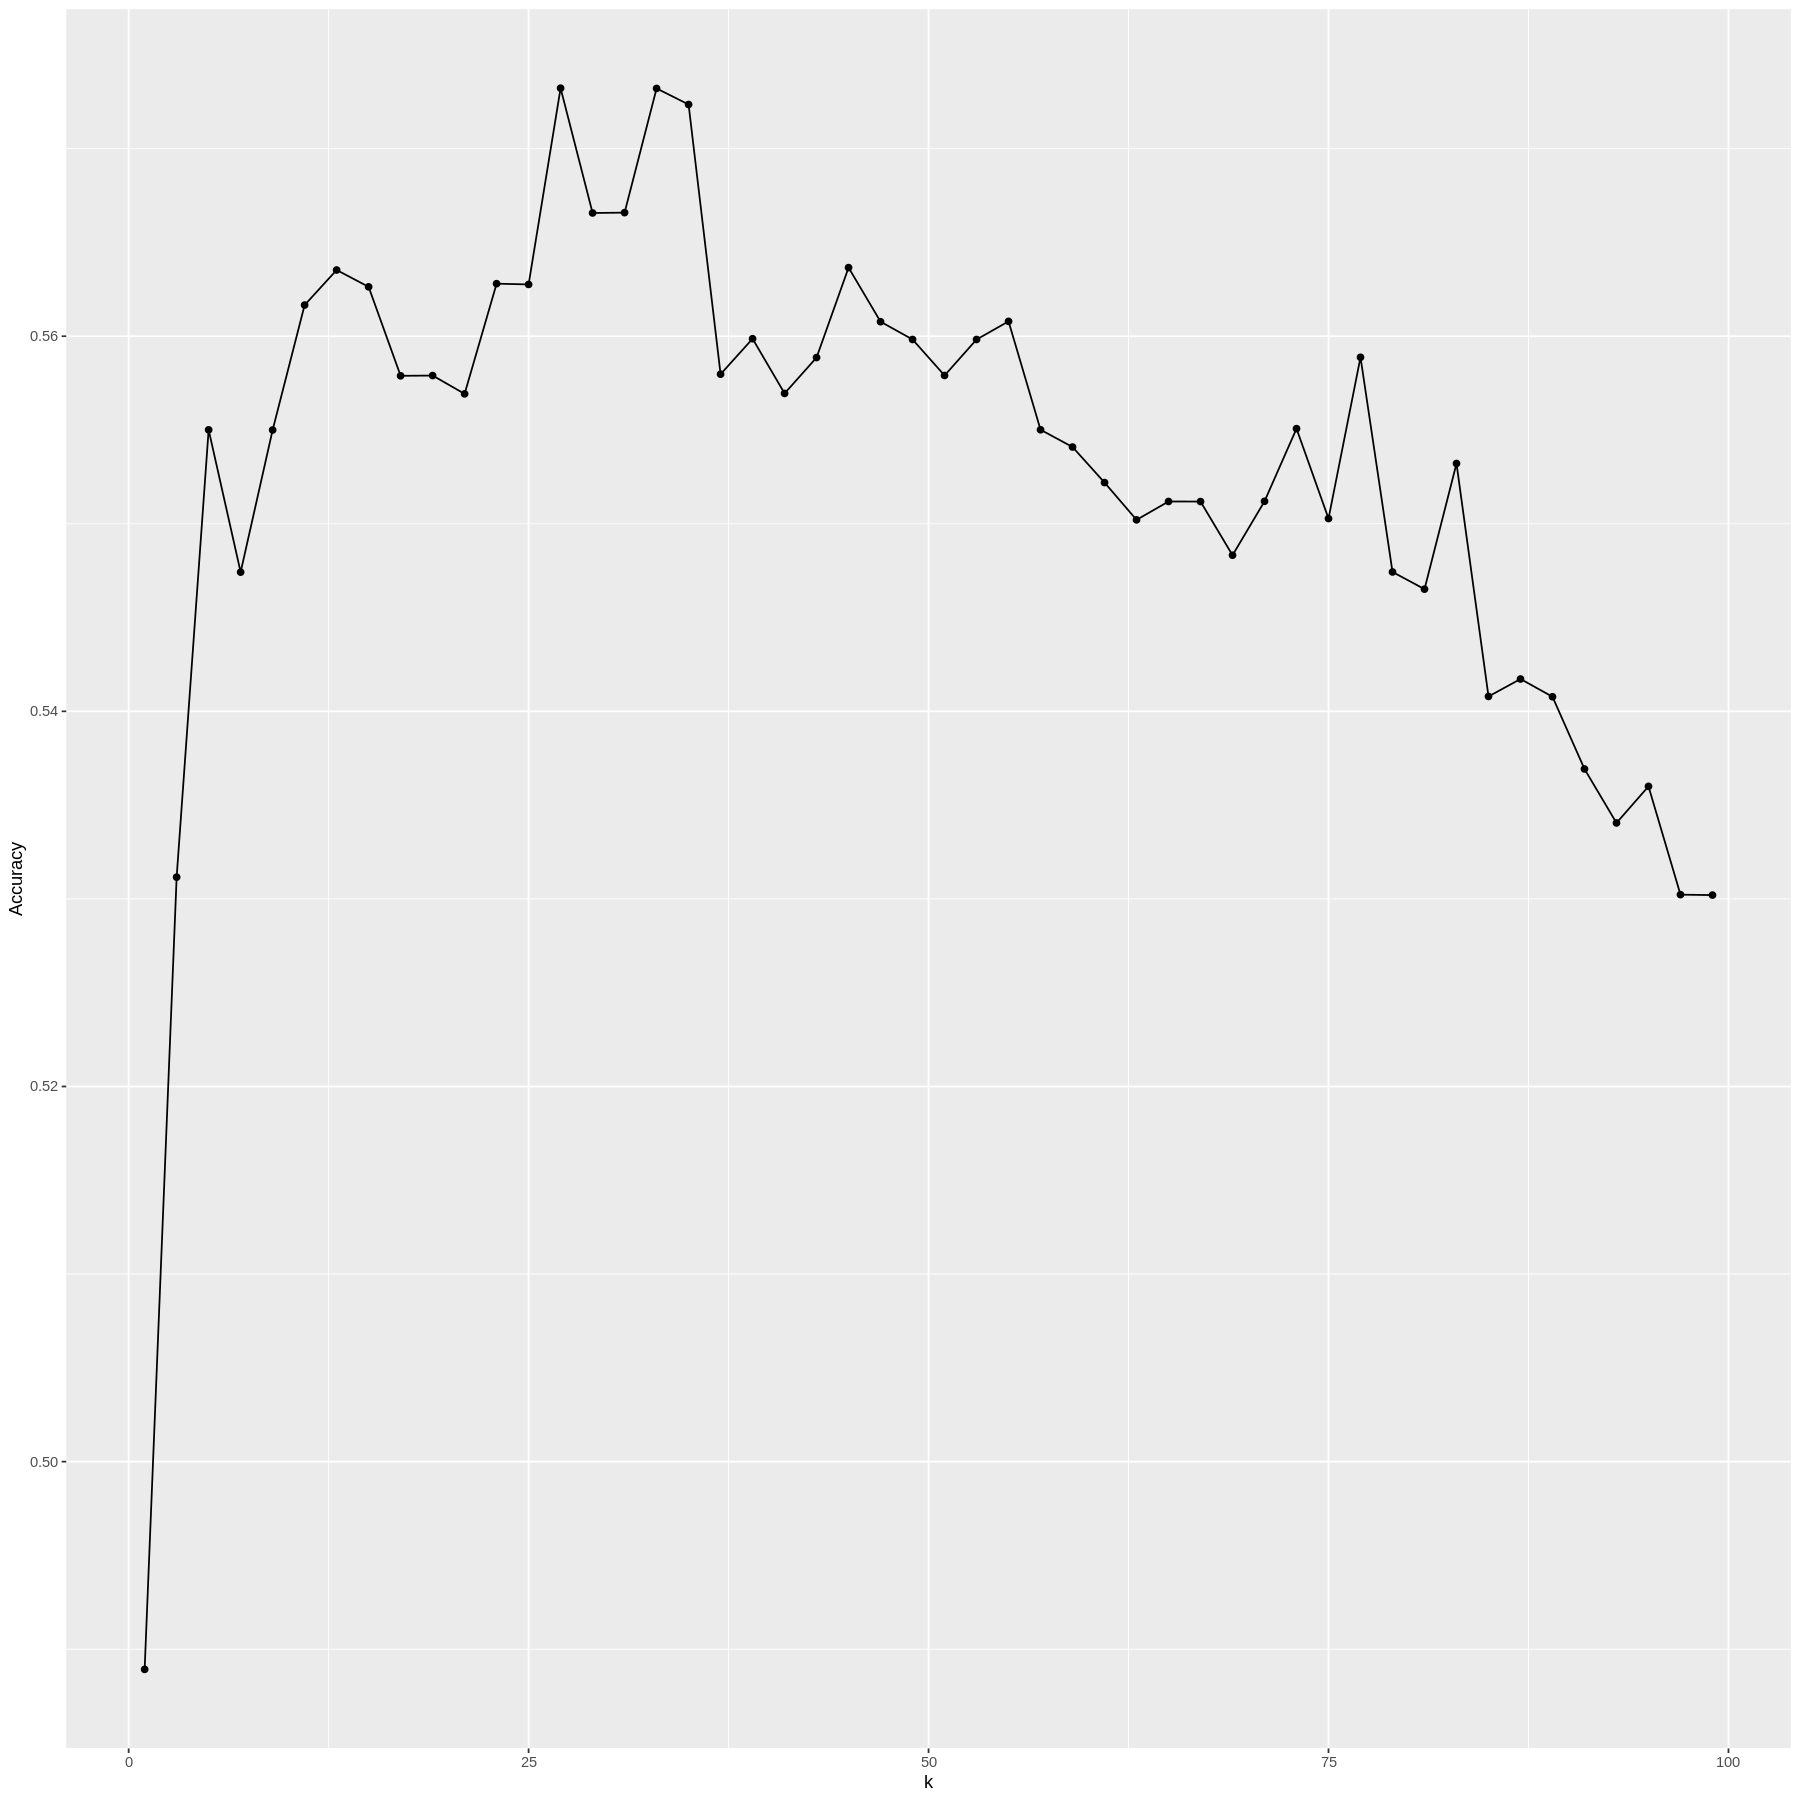

In [16]:
accuracy_upsampling <- classifier_ks$results
ks_plot_upsampling <- ggplot(accuracy_upsampling, aes(x = k, y = Accuracy)) +
           geom_point() +
           geom_line()
ks_plot_upsampling

In [17]:
classifier_k2 <- train(x= balanced_X_train, y= balanced_Y_train, method="knn", tuneGrid= data.frame(k=2), trControl=train_control)
classifier_k2

k-Nearest Neighbors 

3250 samples
   8 predictor
  10 classes: ' CYT', ' ERL', ' EXC', ' ME1', ' ME2', ' ME3', ' MIT', ' NUC', ' POX', ' VAC' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2600, 2600, 2600, 2600, 2600 
Resampling results:

  Accuracy   Kappa    
  0.8538462  0.8376068

Tuning parameter 'k' was held constant at a value of 2

In [18]:
X_test <- testing_set %>% select(-class) %>% data.frame()
Y_test <- testing_set %>% select(class) %>% unlist()

In [19]:
# prediction based on k=2
Y_test_predicted <- predict(object = classifier_k2, X_test)

In [20]:
model_quality_k2 <- confusionMatrix(data = Y_test_predicted, reference = Y_test)
model_quality_k2

Confusion Matrix and Statistics

          Reference
Prediction  CYT  ERL  EXC  ME1  ME2  ME3  MIT  NUC  POX  VAC
       CYT   62    0    1    0    2    2   10   42    0    2
       ERL    0    1    0    0    0    0    0    0    0    0
       EXC    0    0    6    0    2    0    4    1    1    1
       ME1    0    0    2   13    2    1    0    0    0    0
       ME2    1    0    0    0    5    1    3    2    0    0
       ME3    4    0    0    0    0   37    6    6    1    0
       MIT   26    0    1    0    3    0   45   17    1    1
       NUC   38    0    0    0    1    4    2   59    1    3
       POX    1    0    0    0    0    0    2    0    2    0
       VAC    6    0    0    0    0    3    1    1    0    2

Overall Statistics
                                          
               Accuracy : 0.5261          
                 95% CI : (0.4783, 0.5735)
    No Information Rate : 0.3129          
    P-Value [Acc > NIR] : < 2.2e-16       
                                         

In [21]:
# prediction accuracy
model_quality_k2$overall[1]

Accuracy 
0.5260771


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




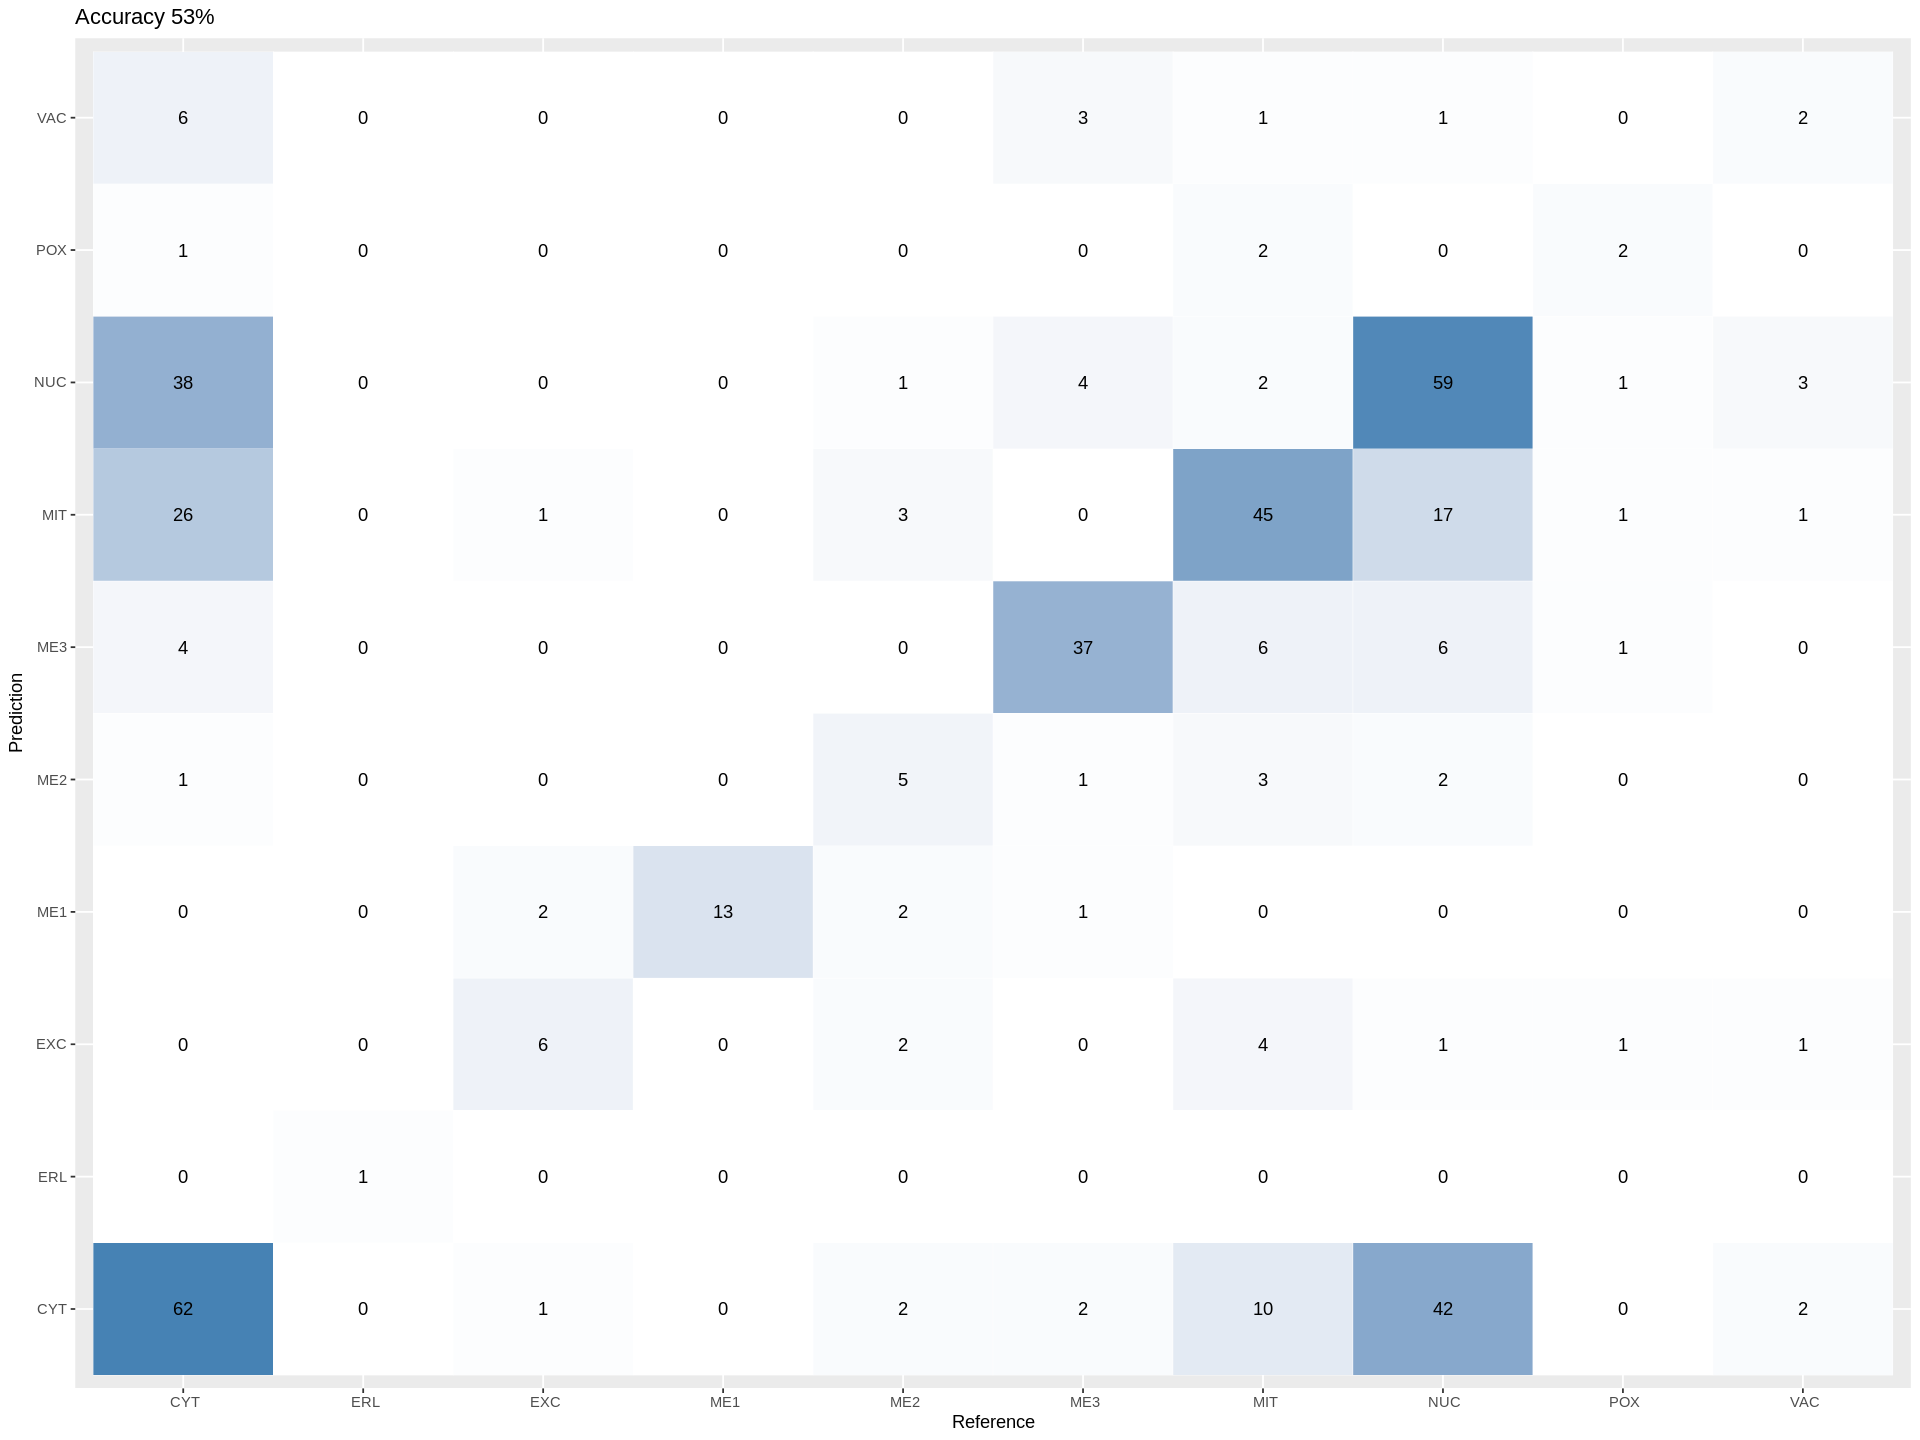

In [22]:
# Visualization of the result--- a visualized confusion matrix
library(ggplot2)
library(scales)

options(repr.plot.width=16, repr.plot.height=12)

ggplotConfusionMatrix <- function(m){
  mytitle <- paste("Accuracy", percent_format()(m$overall[1]))
                   
  p <-
    ggplot(data = as.data.frame(m$table) ,
           aes(x = Reference, y = Prediction)) +
    geom_tile(aes(fill = Freq), colour = "white") +
    scale_fill_gradient(low = "white", high = "steelblue") +
    geom_text(aes(x = Reference, y = Prediction, label = Freq)) +
    theme(legend.position = "none") +
    ggtitle(mytitle)
  return(p)
}

ggplotConfusionMatrix(model_quality_k2)

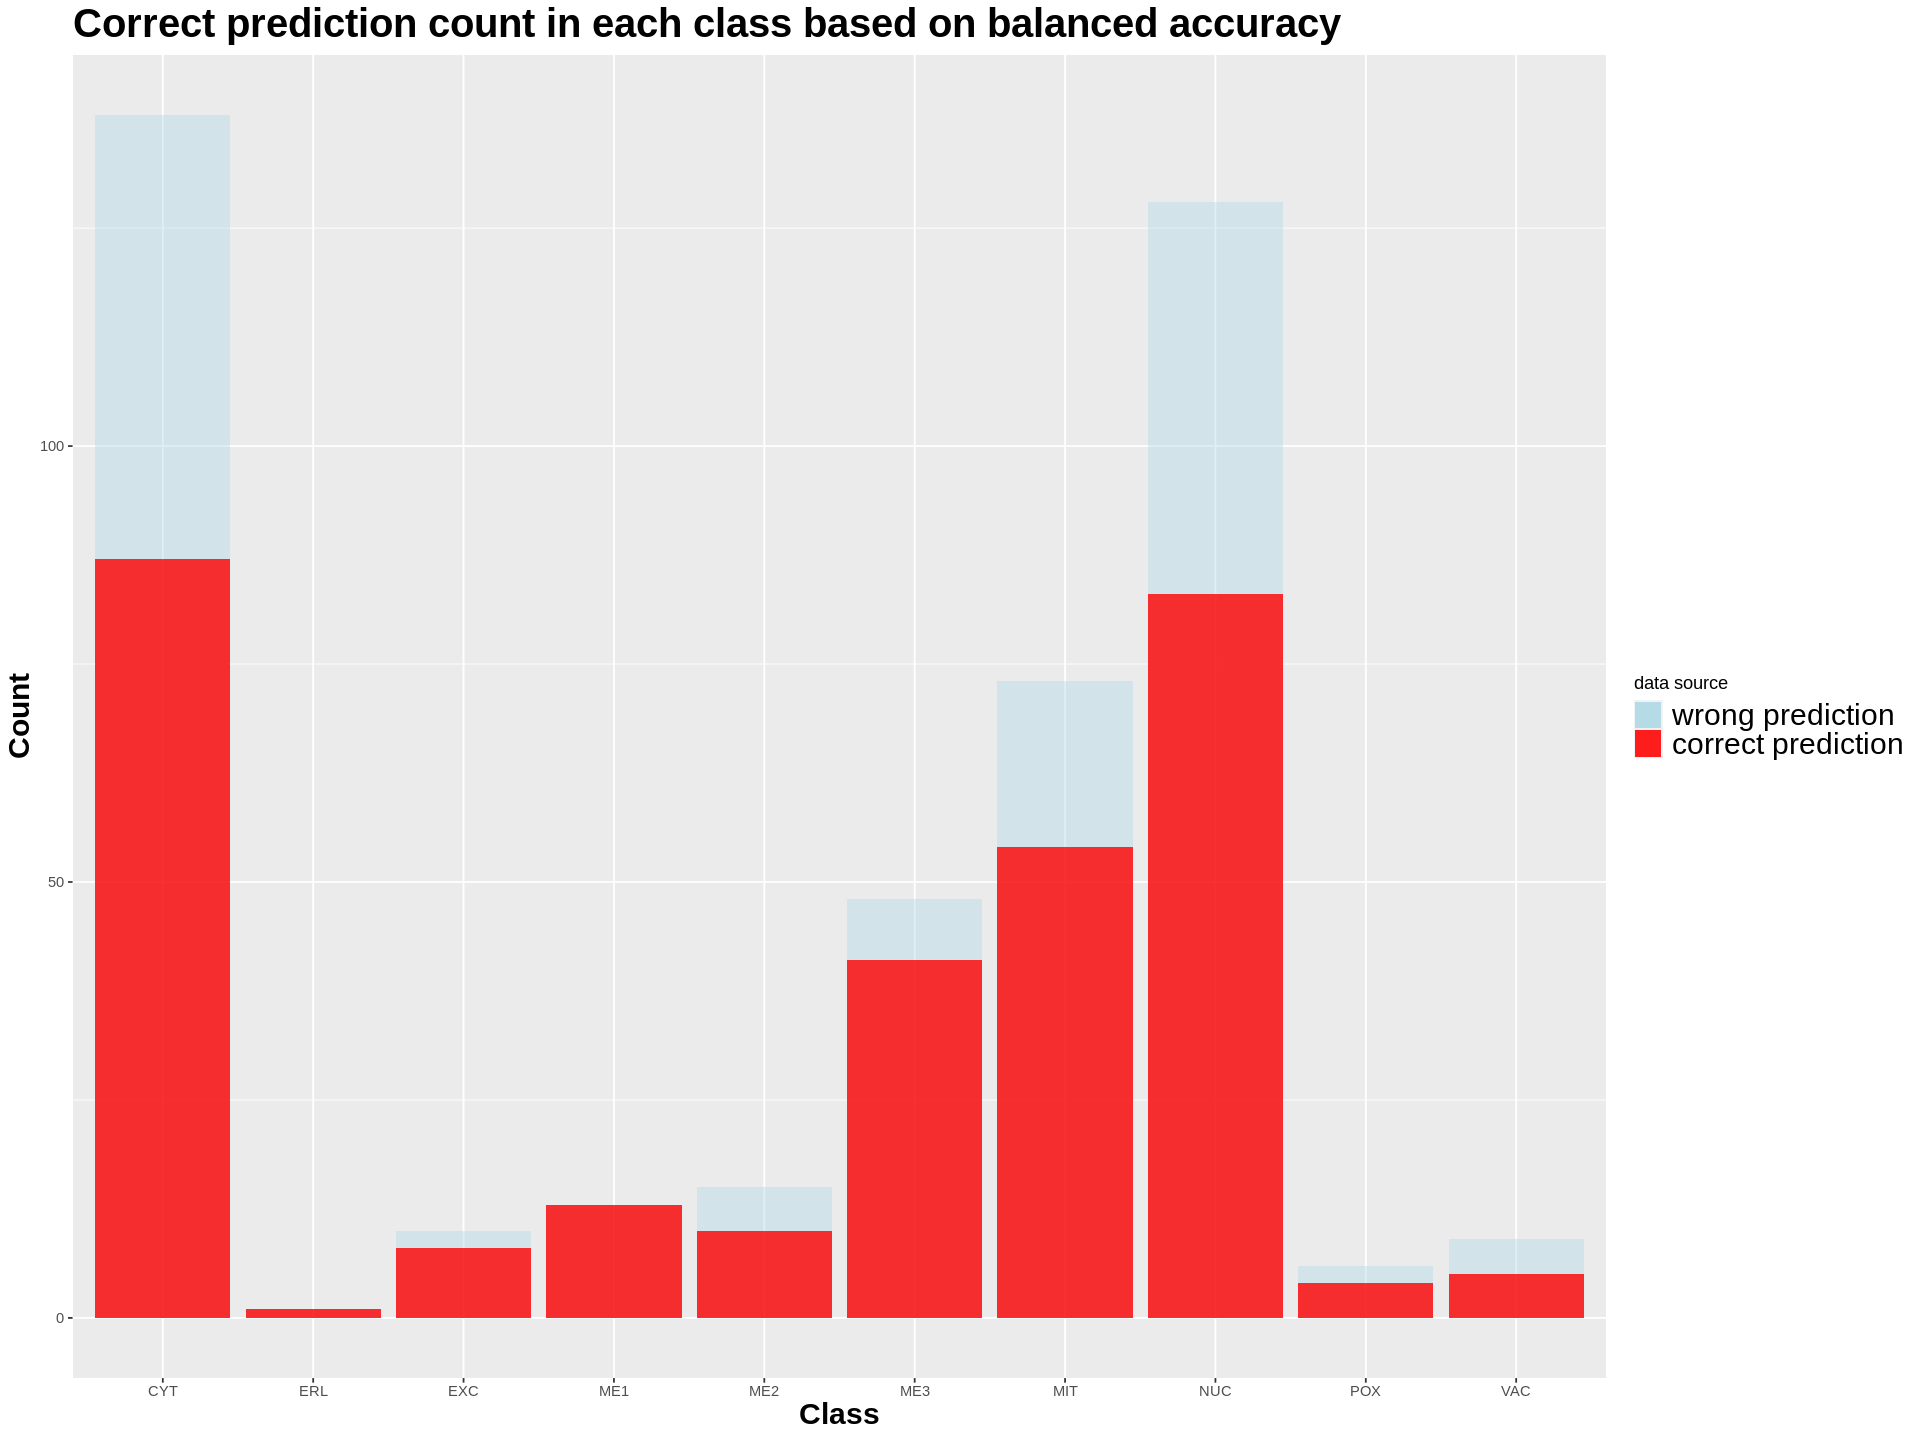

In [23]:
# Visualization of the result--- a filled bar chart

# get balanced accuracy(b_acc)
b_acc=list()
for (i in (1:10)){
    b_acc[i]= model_quality_k2$byClass[i,11]
}

# get predicted instances of each class
count=list()
for (i in (1:10)){
     count[i]= sum(model_quality_k2$table[(10*i-9) : (10*i)])
}

# get number of correct predictions in each class
cls=list("CYT","ERL", "EXC","ME1", "ME2", "ME3", "MIT", "NUC", "POX", "VAC")
stat <- do.call(rbind, Map(data.frame, Class=cls, Balanced_Accuracy= b_acc, Count= count))
stat <- mutate(stat, correct= round(Balanced_Accuracy * Count))

df1 <- stat %>% select(Class, Count)
df2 <- stat %>% select(Class, correct)

# plot showing proportion of correct prediction in each class

ggplot()+
  geom_bar(aes(x= Class, y= Count, fill="a"),stat="identity",data= df1, position ="identity",alpha=.4 ) +
  geom_bar(aes(x= Class, y= correct , fill= "b"),stat="identity", data= df2, position ="identity",alpha=.8  )+
  scale_fill_manual(name = 'data source', 
                     values =c('a'='lightblue', 'b'='red'),
                     labels = c('wrong prediction','correct prediction')) + 
  ggtitle("Correct prediction count in each class based on balanced accuracy")+
  theme(plot.title = element_text(size = 24, face = "bold"),
       axis.title=element_text(size=18,face="bold"),
       legend.text=element_text(size=18))
 

#### The rest is for comparison and further discussion

In [24]:
# comparison(baseline1)
# An alternative approach to balancing data: SMOTE

install.packages("DMwR")
library(DMwR)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.0’
(as ‘lib’ is unspecified)

Loading required package: grid

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [25]:
smo_df  <- training_set %>% mutate_if(is.factor, as.character) 

group1 <- filter(smo_df, class == " CYT" | class == " VAC") %>% mutate(class= as.factor(class))
group2 <- filter(smo_df, class == " NUC" | class == " POX") %>% mutate(class= as.factor(class))
group3 <- filter(smo_df, class == " MIT" | class == " ERL") %>% mutate(class= as.factor(class))
group4 <- filter(smo_df, class == " EXC" | class == " ME1") %>% mutate(class= as.factor(class))
group5 <- filter(smo_df,  class == " ME2" | class == " ME3") %>% mutate(class= as.factor(class))

smo_1 <- SMOTE(class ~ ., group1, perc.over = 600, perc.under = 200) %>% na.omit()
smo_2 <- SMOTE(class ~ ., group2, perc.over = 600, perc.under = 200) %>% na.omit()
smo_3 <- SMOTE(class ~ ., group3, perc.over = 1000, perc.under = 300) %>% na.omit()
smo_4 <- SMOTE(class ~ ., group4, perc.over = 200) %>% na.omit()
smo_5 <- SMOTE(class ~ ., group5, perc.over = 100) %>% na.omit()

In [26]:
# new balanced training set
smo_training_set <- do.call("rbind", list(smo_1, smo_2, smo_3, smo_4, smo_5))
table(smo_training_set$class)


 CYT  VAC  NUC  POX  ERL  MIT  EXC  ME1  ME2  ME3 
 252  147  168   98   29  120   75  100   72   72 

In [27]:
smo_X_train <- smo_training_set %>% select(-class) %>% data.frame() 
smo_Y_train <- smo_training_set %>% select(class) %>% unlist() 


In [28]:
set.seed(1234)
classifier_smo_ks <- train(x= smo_X_train, y= smo_Y_train, method="knn", tuneGrid= ks, trControl=train_control)


In [29]:
set.seed(14)
classifier_smo <- train(x= smo_X_train, y= smo_Y_train, method="knn", tuneGrid= data.frame(k=2), trControl=train_control)


In [30]:
# prediction based on k=2, preprocessed using SMOTE
Y_test_predicted_smo <- predict(object = classifier_smo, X_test)

model_quality_k2_smo <- confusionMatrix(data = Y_test_predicted_smo, reference = Y_test)
model_quality_k2_smo

Warning message in confusionMatrix.default(data = Y_test_predicted_smo, reference = Y_test):
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction  CYT  ERL  EXC  ME1  ME2  ME3  MIT  NUC  POX  VAC
       CYT   59    0    0    0    2    9   11   43    0    3
       ERL    0    1    0    0    0    0    0    0    0    0
       EXC    2    0    8    0    2    0    6    1    1    1
       ME1    0    0    1   13    2    1    0    0    0    0
       ME2    2    0    0    0    6    1    2    2    0    1
       ME3    3    0    0    0    0   19    3    3    0    1
       MIT   11    0    1    0    2    0   42    9    0    0
       NUC   40    0    0    0    0    4    5   59    1    2
       POX    3    0    0    0    0    0    2    2    3    0
       VAC   18    0    0    0    1   14    2    9    1    1

Overall Statistics
                                         
               Accuracy : 0.4785         
                 95% CI : (0.431, 0.5262)
    No Information Rate : 0.3129         
    P-Value [Acc > NIR] : 3.144e-13      
                                         
    

In [31]:
# comparison(baseline2)

# prediction based on k=15, preprocessed using upSampling from caret
set.seed(1234)
classifier_k15 <- train(x= balanced_X_train, y= balanced_Y_train, method="knn", tuneGrid= data.frame(k=15), trControl=train_control)

Y_test_predicted_15 <- predict(object = classifier_k15, X_test)

model_quality_k15 <- confusionMatrix(data = Y_test_predicted_15, reference = Y_test)
model_quality_k15$overall[1]

Accuracy 
0.4399093

## Discussion

After matching different proteins to different areas of localisation through our dataset, we find that there is a correlation between these features and the localisation site of the protein. This aligns with our original hypothesis and has allowed us to produce a reasonably accurate model of prediction. Following this, it is important to note that it is known that there may be multiple localisation sites for a protein. However, due to limitations from the data we have available, our model only attempts to identify one particular location, i.e. the one listed in the given dataset.


Our results align with our initial hypothesis; we were able to use characteristics of the genes to predict localisation with a promising accuracy. Noting that some proteins in yeast cells have orthologs in human cells that enable localization (Gandhi et al., 2006), there is a chance our model may be applicable to similar proteins in human cells as well. The compartmentalization of proteins and enzymes in organelles is a characteristic of all eukaryotic cells so the success of our model indicates that other similar models may also be useful in identifying localization in other eukaryotic cells. This also provides evidence that only from features of a protein’s nucleic acid sequence you are able to make a prediction where the proteins will localize.


Complex versions of models that are comparable to ours have potential to accelerate development of pharmaceuticals by making the identification of protein sites simpler. Most directly, our model could aid in the use of yeast cells to produce various biological compounds (Nielsen, J., 2013). In similar veins, it could also assist researchers in analyzing the effects and causes of chronic illnesses including cardiovascular disease and cancer. Additionally, in the case of any external drug action, the effect acts on the protein interstitial site, therefore our model will help by aiding in determining the location of the protein.

Future research looking at other organisms, will help us become closer to detecting where proteins will localize in humans and therefore work towards cures for various diseases which target specific sites in human cells (Peter, I., 2016). This is a clear direction to move forward in with future research.


## References


Gandhi, T. K. B., Zhong, J., Mathivanan, S., Karthick, L., Chandrika, K. N., Mohan, S. S., & Mishra, G. (2006). Analysis of the human protein interactome and comparison with yeast, worm and fly interaction datasets. Nature genetics, 38(3), 285-293. <br>
Horton, P., & Nakai, K. (1996). A probabilistic classification system for predicting the cellular localization sites of proteins. Proc Int Conf Intell Syst Mol Biol. 4, 109–115. doi: 10.5555/645631.662879 <br>
MBInfo. (2017, November 9). Protein Localization. Retrieved from https://www.mechanobio.info/the-cell/protein-localization/ <br>
Hung, M., & Link, W. (2011). Protein localization in disease and therapy. Journal of Cell Science, 124(20), 3381–3392. doi: 10.1242/jcs.089110 <br>
Nakai, K., & Kanehisa, M. (1991). Expert system for predicting protein localization sites in gram-negative bacteria. Proteins: Structure, Function, and Genetics, 11(2), 95–110. doi: 10.1002/prot.340110203 <br>
Nakai, K., & Kanehisa, M. (1992). A knowledge base for predicting protein localization sites in eukaryotic cells. Genomics, 14(4), 897–911. doi: 10.1016/s0888-7543(05)80111-9 <br>
Nielsen, J. (2013). Production of biopharmaceutical proteins by yeast: advances through metabolic engineering. Retrieved from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3728191/ <br>
Peter, I. (2016, May 26). People and yeast are remarkably similar. Retrieved from https://www.futurity.org/yeast-aging-1125502/ <br>


